In [34]:
import cv2
import numpy as np
import sys
sys.path.append('..')
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,16


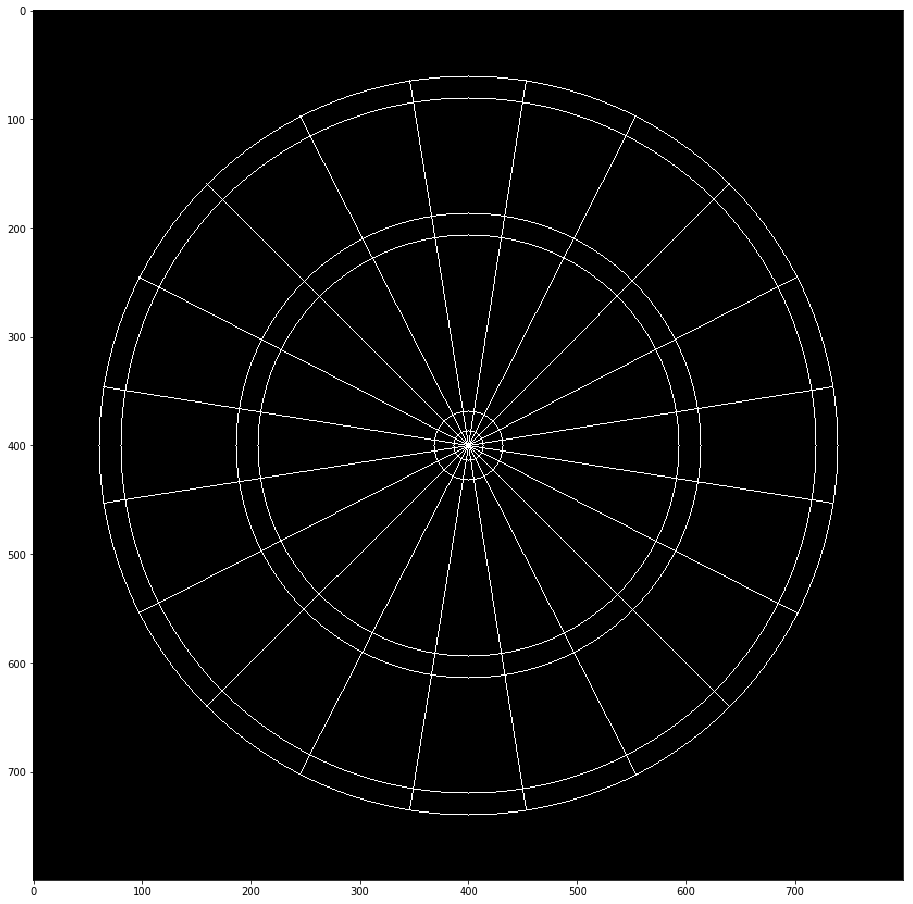

In [36]:
## improve and make circle radius accessible
def drawBoard():
    raw_loc_mat = np.zeros((800, 800, 3))
    radii = [170, 160, 107, 97, 16, 7]
    # Draw Circles
    [cv2.circle(raw_loc_mat, (400, 400), r * 2, (255, 255, 255), 1) for r in radii]
    # Draw Lines
    sectorangle = 2 * math.pi / 20
    for i in range(20):
        cv2.line(raw_loc_mat, (400, 400), (
            int(400 + 170 * 2 * math.cos((0.5 + i) * sectorangle)),
            int(400 + 170 * 2 * math.sin((0.5 + i) * sectorangle))), (255, 255, 255), 1)

    return raw_loc_mat

dart_mask = drawBoard()
dart_mask[np.where(dart_mask>0)]=1
plt.imshow(dart_mask)